In [1]:
import numpy as np
import pandas as pd

from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from datetime import datetime
import itertools

pd.set_option("display.width", 80) # default value
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
df = pd.read_csv("household_power_consumption.txt", sep=";", parse_dates={'ds':['Date', 'Time']}, na_values=['nan', '?'], infer_datetime_format=True,low_memory=False)

In [3]:
df.head(3)

,ds,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.000
1,2006-12-16 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.000
2,2006-12-16 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.000


In [4]:
df.tail(3)

,ds,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
2075256,2010-11-26 21:00:00,0.938,0.000,239.820,3.800,0.000,0.000,0.000
2075257,2010-11-26 21:01:00,0.934,0.000,239.700,3.800,0.000,0.000,0.000
2075258,2010-11-26 21:02:00,0.932,0.000,239.550,3.800,0.000,0.000,0.000


In [5]:
df['Global_active_power']=df['Global_active_power'].apply(lambda x:float(x))
df['Global_reactive_power']=df['Global_reactive_power'].apply(lambda x:float(x))
df['Voltage']=df['Voltage'].apply(lambda x:float(x))
df['Global_intensity']=df['Global_intensity'].apply(lambda x:float(x))
df['Sub_metering_1']=df['Sub_metering_1'].apply(lambda x:float(x))
df['Sub_metering_2']=df['Sub_metering_2'].apply(lambda x:float(x))

In [6]:
df['Global_active_power']=df['Global_active_power'].apply(lambda x: x/60)

In [7]:
df.isnull().sum()

ds                           0
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [8]:
df = df.fillna(df.shift(60*24*7))

In [9]:
df.isnull().sum()

ds                       0
Global_active_power      3
Global_reactive_power    3
Voltage                  3
Global_intensity         3
Sub_metering_1           3
Sub_metering_2           3
Sub_metering_3           3
dtype: int64

In [10]:
df = df.fillna(df.shift(60*24*7))

In [11]:
df.isnull().sum()

ds                       0
Global_active_power      2
Global_reactive_power    2
Voltage                  2
Global_intensity         2
Sub_metering_1           2
Sub_metering_2           2
Sub_metering_3           2
dtype: int64

In [12]:
df = df.fillna(df.shift(60*24))

In [13]:
df.isnull().sum()

ds                       0
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [14]:
df_resample_H = df.resample('H', on="ds").mean() 
df_resample_H.head(3)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
ds,,,,,,,
2006-12-16 17:00:00,0.070,0.229,234.644,18.100,0.000,0.528,16.861
2006-12-16 18:00:00,0.061,0.080,234.580,15.600,0.000,6.717,16.867
2006-12-16 19:00:00,0.057,0.085,233.233,14.503,0.000,1.433,16.683


In [15]:
df_resample_H.reset_index(inplace=True)

In [16]:
df_resample_H.rename(columns={"Global_active_power":"y"}, inplace=True)
df_resample_H = df_resample_H[['ds','y']]

In [17]:
fb_train = df_resample_H[(df_resample_H['ds'] >= '2007-01-01 00:00:00') & (df_resample_H['ds'] < '2010-01-01 00:00:00')]
fb_test = df_resample_H[(df_resample_H['ds'] >= '2010-01-01 00:00:00') & (df_resample_H['ds'] < '2010-10-01 00:00:00')]

In [18]:
print(f"{len(fb_train)} hours of training data \n {len(fb_test)} hours of testing data ")

26304 hours of training data 
 6552 hours of testing data 


In [19]:
round_train = round(len(fb_train)/24)
print(f'days of trening data {round_train}')

days of trening data 1096


In [20]:
round_days = round(len(fb_test)/24)
print(f'days of tresting data {round_days}')

days of tresting data 273


In [21]:
m = Prophet(seasonality_mode='multiplicative', # for our problem
               growth='flat',
               interval_width=0.8,                # 0.8 is default (experimenting)
               changepoint_prior_scale=0.01,      # (experimenting)
               holidays_prior_scale=0.01,         # (experimenting)
               seasonality_prior_scale=0.01,      # (experimenting)
               changepoint_range = 0.8          
               )                                  # mcmc_samples=10 # Uncertainty in seasonality (instead interval_width paramet


In [22]:
m.fit(fb_train)

17:51:25 - cmdstanpy - INFO - Chain [1] start processing
17:51:26 - cmdstanpy - INFO - Chain [1] done processing


In [23]:
future = m.make_future_dataframe(periods=round_days, freq='D', include_history=True)

In [24]:
forecast = m.predict(future)

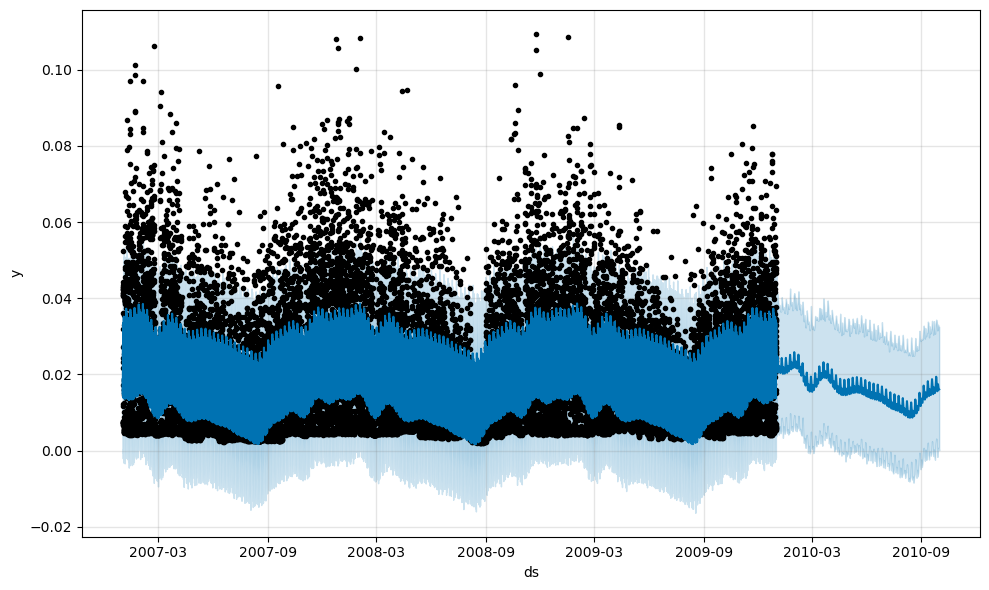

In [25]:
fig1 = m.plot(forecast)

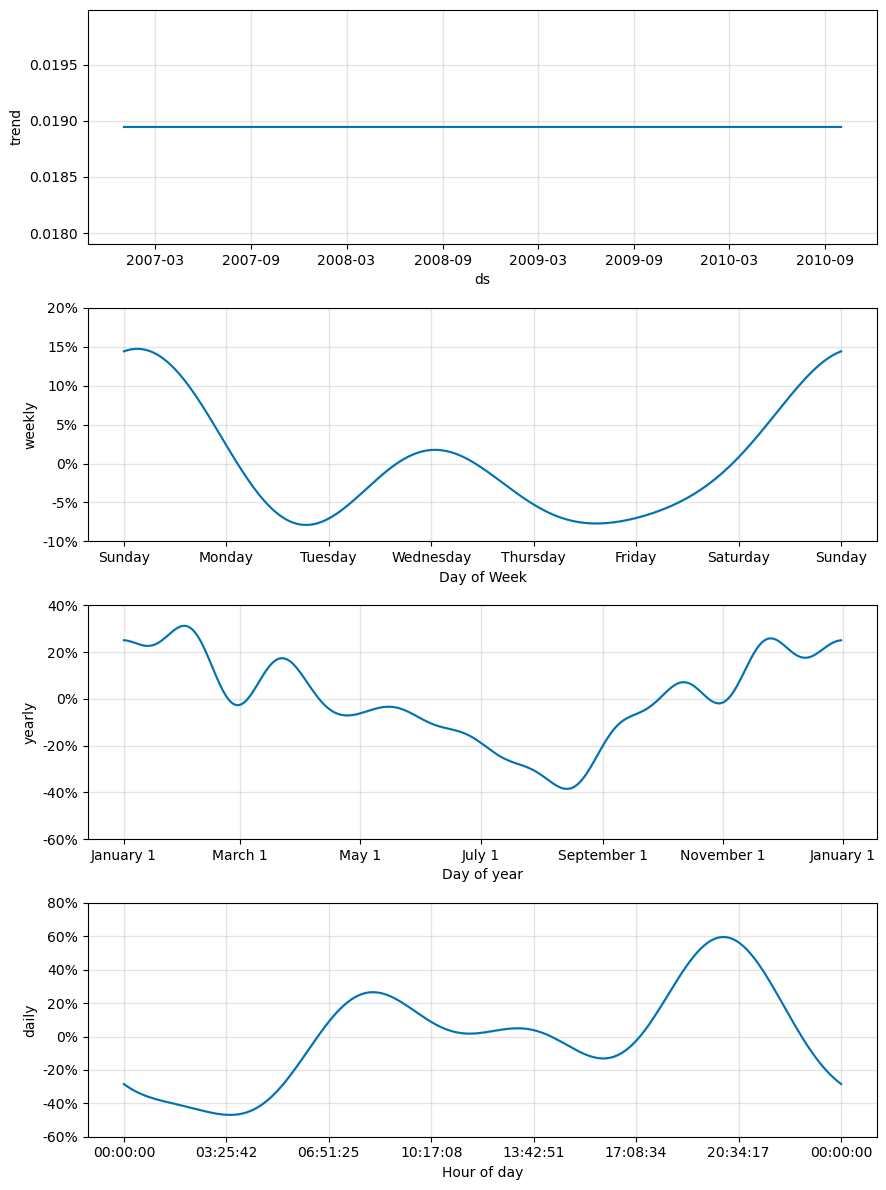

In [26]:
fig2 = m.plot_components(forecast)

In [27]:
cv_days = cross_validation(m,
                         horizon='90 days',
                         period='30 days',
                         initial='540 days',
                         parallel='processes')

In [28]:
cv_p = performance_metrics(cv_days)
cv_p.head(3)

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,9 days 00:00:00,0.000,0.011,0.009,1.045,0.530,0.579,0.905
1,9 days 01:00:00,0.000,0.011,0.009,1.045,0.531,0.580,0.905
2,9 days 02:00:00,0.000,0.011,0.009,1.047,0.532,0.580,0.905


In [30]:
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'holidays_prior_scale' : [0.01, 0.1, 1.0, 10.0],
    'changepoint_range': [0.8, 0.85, 0.9, 0.95]
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmse = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(fb_train)  # Fit model with given params
    cv_days = cross_validation(m, 
                                   horizon='90 days', 
                                   period='30 days',
                                   initial='540 days',
                                   parallel="processes")
    cv_ph = performance_metrics(cv_days, rolling_window=1)
    rmse.append(cv_ph['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmse
print(tuning_results)

17:54:54 - cmdstanpy - INFO - Chain [1] start processing
17:55:03 - cmdstanpy - INFO - Chain [1] done processing
17:56:51 - cmdstanpy - INFO - Chain [1] start processing
17:56:58 - cmdstanpy - INFO - Chain [1] done processing
17:58:42 - cmdstanpy - INFO - Chain [1] start processing
17:58:48 - cmdstanpy - INFO - Chain [1] done processing
18:00:36 - cmdstanpy - INFO - Chain [1] start processing
18:00:39 - cmdstanpy - INFO - Chain [1] done processing
18:02:34 - cmdstanpy - INFO - Chain [1] start processing
18:02:44 - cmdstanpy - INFO - Chain [1] done processing
18:04:32 - cmdstanpy - INFO - Chain [1] start processing
18:04:40 - cmdstanpy - INFO - Chain [1] done processing
18:06:27 - cmdstanpy - INFO - Chain [1] start processing
18:06:32 - cmdstanpy - INFO - Chain [1] done processing
18:08:17 - cmdstanpy - INFO - Chain [1] start processing
18:08:21 - cmdstanpy - INFO - Chain [1] done processing
18:10:14 - cmdstanpy - INFO - Chain [1] start processing
18:10:23 - cmdstanpy - INFO - Chain [1]

20:36:16 - cmdstanpy - INFO - Chain [1] done processing
20:40:25 - cmdstanpy - INFO - Chain [1] start processing
20:40:32 - cmdstanpy - INFO - Chain [1] done processing
20:43:25 - cmdstanpy - INFO - Chain [1] start processing
20:43:34 - cmdstanpy - INFO - Chain [1] done processing
20:46:09 - cmdstanpy - INFO - Chain [1] start processing
20:46:15 - cmdstanpy - INFO - Chain [1] done processing
20:48:30 - cmdstanpy - INFO - Chain [1] start processing
20:48:37 - cmdstanpy - INFO - Chain [1] done processing
20:51:07 - cmdstanpy - INFO - Chain [1] start processing
20:51:14 - cmdstanpy - INFO - Chain [1] done processing
20:53:48 - cmdstanpy - INFO - Chain [1] start processing
20:53:55 - cmdstanpy - INFO - Chain [1] done processing
20:56:26 - cmdstanpy - INFO - Chain [1] start processing
20:56:31 - cmdstanpy - INFO - Chain [1] done processing
20:58:55 - cmdstanpy - INFO - Chain [1] start processing
20:59:03 - cmdstanpy - INFO - Chain [1] done processing
21:01:18 - cmdstanpy - INFO - Chain [1] 

00:10:12 - cmdstanpy - INFO - Chain [1] done processing
00:14:08 - cmdstanpy - INFO - Chain [1] start processing
00:14:28 - cmdstanpy - INFO - Chain [1] done processing
00:18:04 - cmdstanpy - INFO - Chain [1] start processing
00:18:27 - cmdstanpy - INFO - Chain [1] done processing
00:22:26 - cmdstanpy - INFO - Chain [1] start processing
00:22:44 - cmdstanpy - INFO - Chain [1] done processing
00:26:41 - cmdstanpy - INFO - Chain [1] start processing
00:27:01 - cmdstanpy - INFO - Chain [1] done processing
00:30:54 - cmdstanpy - INFO - Chain [1] start processing
00:31:14 - cmdstanpy - INFO - Chain [1] done processing
00:34:50 - cmdstanpy - INFO - Chain [1] start processing
00:35:13 - cmdstanpy - INFO - Chain [1] done processing
00:39:15 - cmdstanpy - INFO - Chain [1] start processing
00:39:33 - cmdstanpy - INFO - Chain [1] done processing
00:43:28 - cmdstanpy - INFO - Chain [1] start processing
00:43:48 - cmdstanpy - INFO - Chain [1] done processing
00:47:38 - cmdstanpy - INFO - Chain [1] 

05:52:26 - cmdstanpy - INFO - Chain [1] done processing
05:57:13 - cmdstanpy - INFO - Chain [1] start processing
05:57:36 - cmdstanpy - INFO - Chain [1] done processing
06:02:48 - cmdstanpy - INFO - Chain [1] start processing
06:03:15 - cmdstanpy - INFO - Chain [1] done processing
06:08:00 - cmdstanpy - INFO - Chain [1] start processing
06:08:31 - cmdstanpy - INFO - Chain [1] done processing
06:14:01 - cmdstanpy - INFO - Chain [1] start processing
06:14:38 - cmdstanpy - INFO - Chain [1] done processing
06:19:32 - cmdstanpy - INFO - Chain [1] start processing
06:19:55 - cmdstanpy - INFO - Chain [1] done processing
06:25:09 - cmdstanpy - INFO - Chain [1] start processing
06:25:37 - cmdstanpy - INFO - Chain [1] done processing
06:30:19 - cmdstanpy - INFO - Chain [1] start processing
06:30:45 - cmdstanpy - INFO - Chain [1] done processing
06:35:41 - cmdstanpy - INFO - Chain [1] start processing
06:36:10 - cmdstanpy - INFO - Chain [1] done processing
06:41:07 - cmdstanpy - INFO - Chain [1] 

     changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale  \
0                      0.001                    0.010                 0.010   
1                      0.001                    0.010                 0.010   
2                      0.001                    0.010                 0.010   
3                      0.001                    0.010                 0.010   
4                      0.001                    0.010                 0.100   
..                       ...                      ...                   ...   
251                    0.500                   10.000                 1.000   
252                    0.500                   10.000                10.000   
253                    0.500                   10.000                10.000   
254                    0.500                   10.000                10.000   
255                    0.500                   10.000                10.000   

     changepoint_range  rmse  
0                0.8

In [32]:
best_params = all_params[np.argmin(rmse)]
print(best_params)

{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'changepoint_range': 0.85}


### New Prophet model with best parameters

In [ ]:


m_h = Prophet(seasonality_mode='multiplicative',
              changepoint_prior_scale = 0.001,
              seasonality_prior_scale = 0.01,
              holidays_prior_scale = 0.01,
              changepoint_range = 0.85,
               growth='flat',
               interval_width=0.8)                                

In [35]:
m_h.fit(fb_train)

10:58:03 - cmdstanpy - INFO - Chain [1] start processing
10:58:05 - cmdstanpy - INFO - Chain [1] done processing


In [36]:
future_h = m_h.make_future_dataframe(periods=round_days, freq='D', include_history=True)

In [37]:
forecast_h = m_h.predict(future_h)

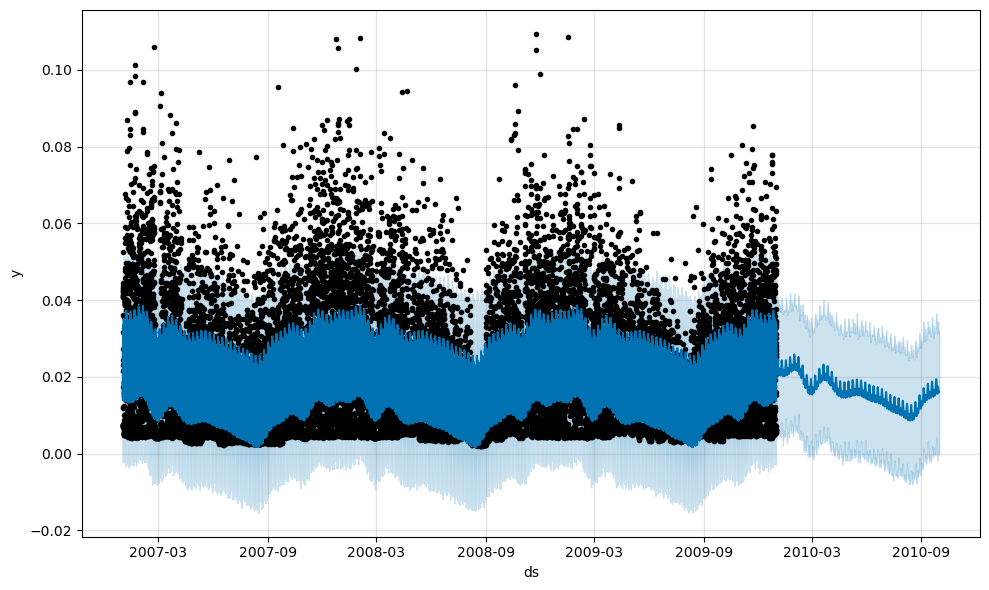

In [38]:
fig1_h = m_h.plot(forecast_h)

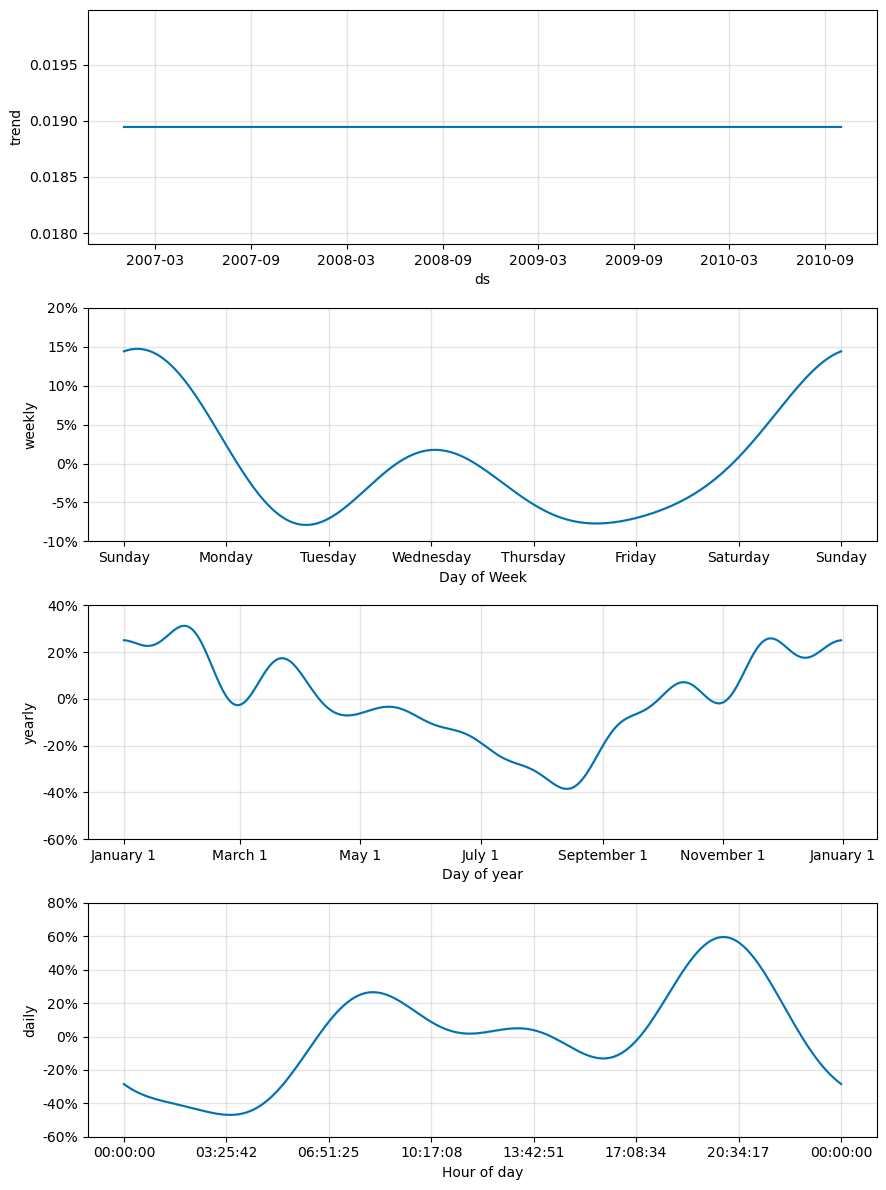

In [39]:
fig2_h = m_h.plot_components(forecast_h)

In [40]:
cv_days_h = cross_validation(m_h,
                         horizon='90 days',
                         period='30 days',
                         initial='540 days',
                         parallel='processes')

In [42]:
cv_p_h = performance_metrics(cv_days_h)
cv_p_h.head(3)

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,9 days 00:00:00,0.000,0.011,0.009,1.045,0.530,0.579,0.905
1,9 days 01:00:00,0.000,0.011,0.009,1.045,0.531,0.580,0.905
2,9 days 02:00:00,0.000,0.011,0.009,1.047,0.532,0.580,0.905


# Comparing two models

In [53]:
cv_compare = cv_p.compare(cv_p_h, keep_shape=True)
cv_compare.head(3)

horizon        mse       rmse        mae       mape       mdape       smape  \
     self other self other self other self other self other  self other  self   
0     NaT   NaT  NaN   NaN  NaN   NaN  NaN   NaN  NaN   NaN   NaN   NaN   NaN   
1     NaT   NaT  NaN   NaN  NaN   NaN  NaN   NaN  NaN   NaN   NaN   NaN   NaN   
2     NaT   NaT  NaN   NaN  NaN   NaN  NaN   NaN  NaN   NaN   NaN   NaN   NaN   

        coverage        
  other     self other  
0   NaN    0.905 0.905  
1   NaN    0.905 0.905  
2   NaN    0.905 0.905

In [54]:
cv_compare.max()

horizon   self      NaT
          other     NaT
mse       self      NaN
          other     NaN
rmse      self      NaN
          other     NaN
mae       self      NaN
          other     NaN
mape      self      NaN
          other     NaN
mdape     self      NaN
          other     NaN
smape     self      NaN
          other     NaN
coverage  self    0.905
          other   0.907
dtype: object